In [1]:
import cv2, os, json, math, time, tqdm
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict, defaultdict
from zipfile import ZipFile
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon 
from matplotlib.collections import PatchCollection
from IPython.display import display, HTML

DIR = './data' #@@@ OVERRIDE: Path of folder with all annotations and images 

## DATASETS ANALYSIS
**Dataset Folder Structure**  
Images and annotations have been organized in a folder with the following structure. 'USER' refers to DeepFashion2 wild images, while 'SHOP' refers to DeepFashion2 street images.

- data
    - ```shop_df2```
        * ```train```
            - image: ```df2_train_shop``` (filenames from 0 to 2499)
            - annos: coco_df2_ts_2500.json
        * ```validation```
            - image: ```df2_val_shop``` (filenames from 0 to 499)
            - annos: coco_df2_vs_500.json
    - ```user_df2```
        * ```train```
            - image: ```df2_train_user``` (filenames from 0 to 4999)
            - annos: coco_df2_tu_5000.json
        * ```validation```
            - image: ```df2_val_user``` (filenames from 0 to 499)
            - annos: coco_df2_vu_500.json
    - ```shop_user_df2```
        * ```validation``` 
            - image: ```df2_val_shop_user``` (filenames from 0 to 999)
            - annos: coco_df2_vsu_100.json    
    - test
        - image: ```dlcv_test``` (filenames from 0 to 499)
        - annos: coco_test_500.json

**Dataset Creation**  
Train and Validation Sets - Images are from DeepFashion2 dataset, specifically the validation set. Images are 50% from fashion e-commerce (shop) and 50% from photos of consumers (user). Annotations have been created manually with VGG Image Annotator and converted to COCO format using the function in ```convertes.ipynb```. Categories have been defined considering the catalogs of major fahsion e-commerce ([macy's](#https://www.macys.com/), [zalando](#https://www.zalando.it/), [asos](#https://www.asos.com/women/), [yoox](https://www.yoox.com/)) and trying to do an intersection of Fashionpedia's, ModaNet's and DeepFashion's classes. 

Test Set - Images are from Instagram. Annotations have been created manually from scratch with VGG Image Annotator and converted to COCO format using the function in ```convertes.ipynb```. Same story for the categories. 

In [3]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

def plot_annotations(img_path, anns, cats):
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.subplot(1, 2, 1)
    plt.axis('off')
    imgArray = io.imread(img_path)
    plt.imshow(imgArray)

    plt.subplot(1, 2, 2)
    plt.imshow(imgArray)
    plt.axis('off')

    ax = plt.gca()
    ax.set_autoscale_on(False)

    polygons = []
    color = []
    maps = []

    for ann in anns: #anns = [{annotation1}, {}, {}]
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0] # for each annotation get 3 random numbers [0, 1]
        for seg in ann['segmentation']:                    # for each segmentation [list of lists] get vertices      
            poly = np.array(seg).reshape((int(len(seg)/2), 2)) # get a matrix len(seg)/2 x 2 (each vertex is an array)
            polygons.append(Polygon(poly))
            color.append(c) 
            if (ann['id'], cats[ann['category_id']-1]['name'], mcolors.to_hex(c)) not in maps:
                maps.append((ann['id'], cats[ann['category_id']-1]['name'], mcolors.to_hex(c)))

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

    #  text
    for i, ann in enumerate(anns):
        print("Segmentation {}:".format(i))
        print("\tCategory: {}".format(cats[ann["category_id"]-1]["name"]))

    # legend
    pops = [mpatches.Patch(color=maps[i][2], label=maps[i][1]) for i in range(len(maps))]
    plt.legend(handles=pops, fontsize='large');

def categories_frequency(dataset_annos, name_dataset, relative_frequency=False):
    counts = []
    num_masks = len(dataset_annos['annotations'])
    cat_count =  dict(OrderedDict(Counter([d['category_id'] for d in dataset_annos['annotations']]).most_common()))
    cats = [i for i in range(1, len(dataset_annos['categories'])+1)]
    if len(counts) != len(dataset_annos['categories']):
        adding = {i:0 for i in cats if i not in cat_count.keys()}
        cat_count_all = cat_count | adding
    for k, v in cat_count_all.items():
        counts.append([dataset_annos['categories'][k-1]['name'], v, round((v/num_masks)*100, 1)])
    df = pd.DataFrame(counts, columns = ['category', '#masks', 'frequency'])
    
    # Plot
    fig, ax = plt.subplots(figsize=(17,5))
    fig.suptitle(name_dataset.upper(), fontweight='bold')
    x = df['category'].tolist()
    if relative_frequency: 
        y = df['frequency'].tolist()
        ax.set_ylabel('Number of masks (%)')
    else:
        y = df['#masks'].tolist()
        ax.set_ylabel('Number of masks')
    #clrs = ['grey' if x >  else 'red' for x in y]
    ax.bar(x,y, width=0.4)
    ax.set_title('Number of masks by CATEGORY')
    labels = ax.get_xticklabels()
    for label, v in zip(labels, y):
        if v == 0:
            label.set_color('r')

    fig.autofmt_xdate(rotation=45)
    plt.show();
    return df.round(decimals=2)

def category_area(dataset_annos):
    a = defaultdict(list)
    for d in dataset_annos['annotations']:
        img = dataset_annos['images'][d['image_id']]
        img_size = img['width']*img['height']*3
        a[d['category_id']].append(d['area']/img_size)

    avg_area_cat = {k:round(np.average(v)*100,2) for k,v in a.items()}
    cats = [i for i in range(1, len(dataset_annos['categories'])+1)]
    if len(avg_area_cat) != len(dataset_annos['categories']):
        adding = {i:0 for i in cats if i not in avg_area_cat.keys()}
        avg_area_cat = avg_area_cat | adding
    avg_area_cat = {dataset_annos['categories'][k-1]['name']:round(v,1) for k,v in dict(sorted(avg_area_cat.items(), key = lambda x: x[1], reverse = True)).items()}
    df = pd.DataFrame({'category':avg_area_cat.keys(), 'avg(segmentation area) - % of image area':avg_area_cat.values()})
    return df.round(decimals=2)

def img_resolution(dataset_annos):
    return round(np.mean([d['width']*d['height']*3 for d in dataset_annos['images']])/1000000,2)

def img_type(dataset_annos):
    map = {"0" : '1_person', "1":'people', "2":'no_people', "0_3":'1_person_selfie', "1_3":'people_selfie'}
    num_imgs = len(dataset_annos['images'])
    dd = []
    for d in dataset_annos['images']:
        type = '_'.join([i.strip() for i in d['people']])
        if type in map.keys():
            dd.append(type)
        else:
            dd.append('0')

    count = {map[k]:round(v/num_imgs*100, 2) for k,v in Counter(dd).items()}
    df = pd.DataFrame(count, index=['%images'])
    return df.round(decimals=2)

def compute_statistics(dataset_annos, index:list):
    dict_numb = {
        '#categories' : len(dataset_annos['categories']),
        '#images' : len(dataset_annos['images']),
        '#masks' : len(dataset_annos['annotations'])}
    stats = pd.DataFrame(dict_numb, index=index)
    stats['avg(#masks) - per image'] = round(stats.iloc[:, 2]/stats.iloc[:, 1], 2)

    lens = []
    try:
        for d in dataset_annos['annotations']:
            assert len(d['segmentation']) == 1
            lens.append(len(d['segmentation'][0]))
        stats['avg(#vertices) - per mask'] = round(np.mean(lens),2)
    except:
        pass
    return stats.round(decimals=2)

def show_all(annos_json, name:str):
    print('\nStatistics about annotation')
    display(compute_statistics(annos_json, [name]))
    print('\nStatistics about images')
    print('\navg(image size) - Mpx: ', img_resolution(annos_json))
    display(img_type(annos_json))
    print('\nStatistics about categories')
    freq = categories_frequency(annos_json, name)
    area = category_area(annos_json)
    display_side_by_side([freq.round(decimals=2), area.round(decimals=2)], ['Satistics by category', ''])   

### TRAIN - VALIDATION SETS

#### 1. DeepFashion2 - User (WILD)

##### Train Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
DeepFashion2 - Train - User,30,5000,7897,1.58,155.89



Statistics about images

avg(image size) - Mpx:  0.85


,1_person,1_person_selfie,no_people,people,people_selfie
%images,40.6,27.24,30.88,0.72,0.56



Statistics about categories


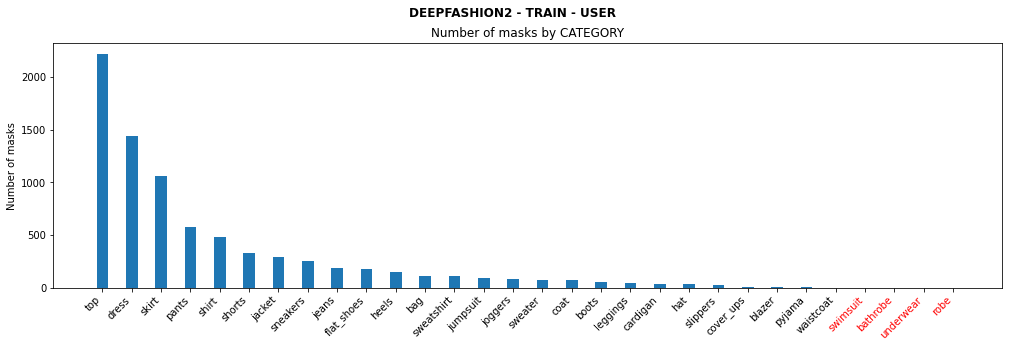

,category,#masks,frequency
0,top,2212,28.000000
1,dress,1440,18.200000
2,skirt,1057,13.400000
3,pants,580,7.300000
4,shirt,483,6.100000
5,shorts,332,4.200000
6,jacket,288,3.600000
7,sneakers,252,3.200000
8,jeans,184,2.300000
9,flat_shoes,180,2.300000


In [4]:
path_df2tu = os.path.join(DIR, 'user_df2/train/coco_df2_tu_5000.json')
df2tu = json.load(open(path_df2tu))
show_all(df2tu, 'DeepFashion2 - Train - User')

##### Validation Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
DeepFashion2 - Validation - User,30,505,925,1.83,144.44



Statistics about images

avg(image size) - Mpx:  0.87


,no_people,1_person,1_person_selfie,people,people_selfie
%images,8.91,61.58,28.12,0.79,0.59



Statistics about categories


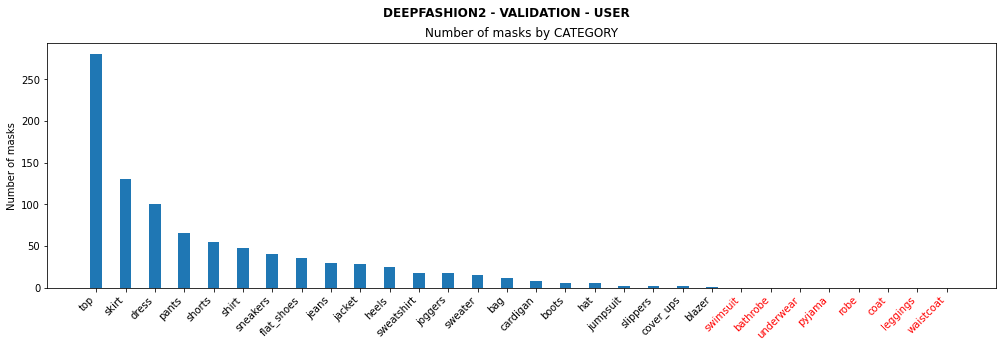

,category,#masks,frequency
0,top,280,30.300000
1,skirt,131,14.200000
2,dress,100,10.800000
3,pants,66,7.100000
4,shorts,55,5.900000
5,shirt,48,5.200000
6,sneakers,40,4.300000
7,flat_shoes,35,3.800000
8,jeans,29,3.100000
9,jacket,28,3.000000


In [5]:
path_df2vu =  os.path.join(DIR, 'user_df2/validation/coco_df2_vu_500.json')
df2vu = json.load(open(path_df2vu))
show_all(df2vu, 'DeepFashion2 - Validation - User')

#### 2. DeepFashion2 - Shop (STREET)

##### Train Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
DeepFashion2 - Train - Shop,30,2500,6002,2.4,141.11



Statistics about images

avg(image size) - Mpx:  1.63


,1_person,people,no_people,1_person_selfie
%images,94.88,0.84,1.68,2.6



Statistics about categories


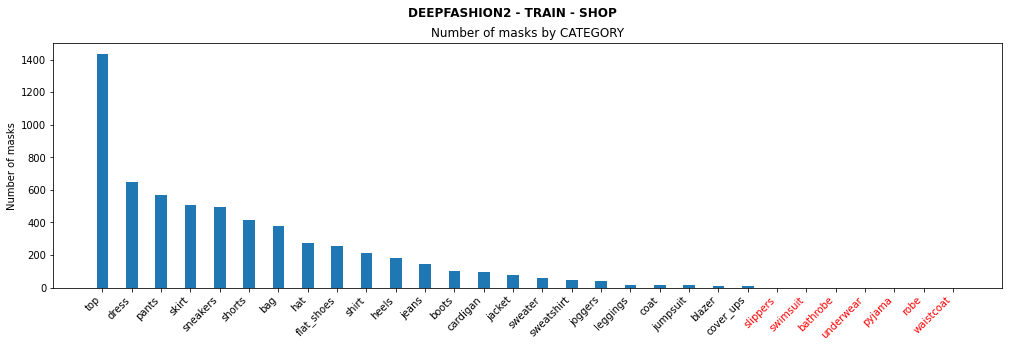

,category,#masks,frequency
0,top,1431,23.800000
1,dress,649,10.800000
2,pants,569,9.500000
3,skirt,507,8.400000
4,sneakers,497,8.300000
5,shorts,418,7.000000
6,bag,381,6.300000
7,hat,274,4.600000
8,flat_shoes,256,4.300000
9,shirt,211,3.500000


In [6]:
path_df2ts =  os.path.join(DIR, 'shop_df2/train/coco_df2_ts_2500.json')
df2ts = json.load(open(path_df2ts))
show_all(df2ts, 'DeepFashion2 - Train - Shop')

##### Validation Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
DeepFashion2 - Validation - Shop,30,501,1131,2.26,146.89



Statistics about images

avg(image size) - Mpx:  1.64


,1_person,1_person_selfie,no_people,people
%images,94.41,2.79,2.0,0.8



Statistics about categories


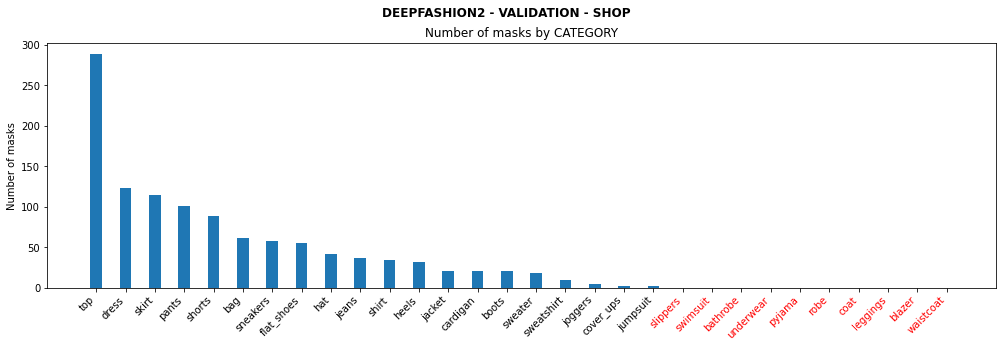

,category,#masks,frequency
0,top,288,25.500000
1,dress,123,10.900000
2,skirt,115,10.200000
3,pants,101,8.900000
4,shorts,88,7.800000
5,bag,61,5.400000
6,sneakers,58,5.100000
7,flat_shoes,55,4.900000
8,hat,41,3.600000
9,jeans,37,3.300000


In [7]:
path_df2vs =  os.path.join(DIR, 'shop/validation/coco_df2_vs_500.json')
df2vs = json.load(open(path_df2vs))
show_all(df2vs, 'DeepFashion2 - Validation - Shop')

#### 3. DeepFashion2 - User + Shop (WILD + STREET)

##### Train Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
DeepFashion2 - Train - User + Shop,30,7500,13899,1.85,149.51



Statistics about images

avg(image size) - Mpx:  1.11


,1_person,1_person_selfie,no_people,people,people_selfie
%images,58.69,19.03,21.15,0.76,0.37



Statistics about categories


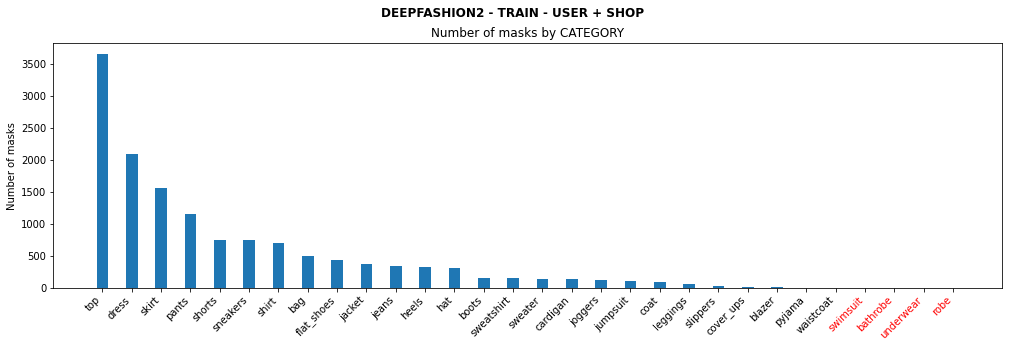

,category,#masks,frequency
0,top,3643,26.200000
1,dress,2089,15.000000
2,skirt,1564,11.300000
3,pants,1149,8.300000
4,shorts,750,5.400000
5,sneakers,749,5.400000
6,shirt,694,5.000000
7,bag,495,3.600000
8,flat_shoes,436,3.100000
9,jacket,366,2.600000


In [8]:
# First need to merge two separate json file of Train - Shop and Train - User 
ctu = df2tu.copy()
cts = df2ts.copy()

i = 5000
for d in cts['images']:
    d['id'] = i
    d['file_name'] = str(i).zfill(6)+'.jpg'
    ctu['images'].append(d)
    i+=1

j = 7897
for d in cts['annotations']:
    d['id'] = j
    d['image_id'] += 5000
    ctu['annotations'].append(d)
    j += 1

df2tsu = {
    'info':df2ts['info'],
    'lincenses': '', 
    'images': ctu['images'], 
    'annotations' : ctu['annotations'],
    'categories': df2ts['categories']
}

show_all(df2tsu, 'DeepFashion2 - Train - User + Shop')   

##### Validation Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
DeepFashion2 - Validation - User + Shop,30,1006,2056,2.04,145.79



Statistics about images

avg(image size) - Mpx:  1.26


,1_person,1_person_selfie,no_people,people,people_selfie
%images,77.93,15.51,5.47,0.8,0.3



Statistics about categories


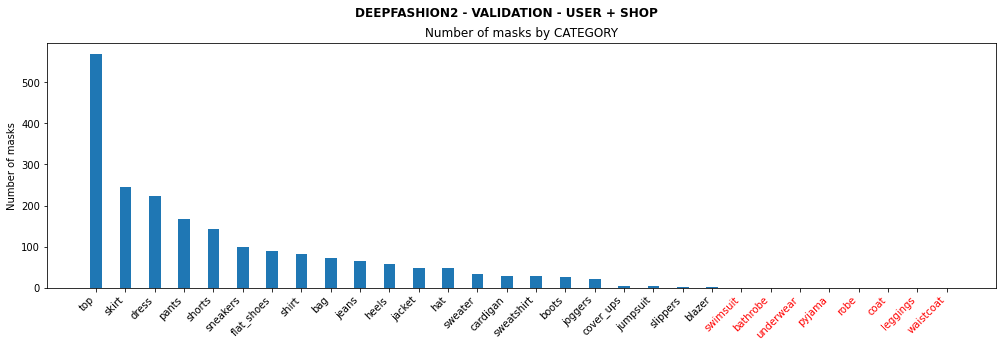

,category,#masks,frequency
0,top,568,27.600000
1,skirt,246,12.000000
2,dress,223,10.800000
3,pants,167,8.100000
4,shorts,143,7.000000
5,sneakers,98,4.800000
6,flat_shoes,90,4.400000
7,shirt,82,4.000000
8,bag,72,3.500000
9,jeans,66,3.200000


In [9]:
path_df2vsu =  os.path.join(DIR, 'shop_user_df2/validation/coco_df2_vsu_1000.json')
df2vsu = json.load(open(path_df2vsu))
show_all(df2vsu, 'DeepFashion2 - Validation - User + Shop')

### Test Set


Statistics about annotation


,#categories,#images,#masks,avg(#masks) - per image,avg(#vertices) - per mask
Test,30,500,1893,3.79,82.12



Statistics about images

avg(image size) - Mpx:  3.21


,people_selfie,no_people,1_person,people,1_person_selfie
%images,3.8,3.4,61.0,26.0,5.8



Statistics about categories


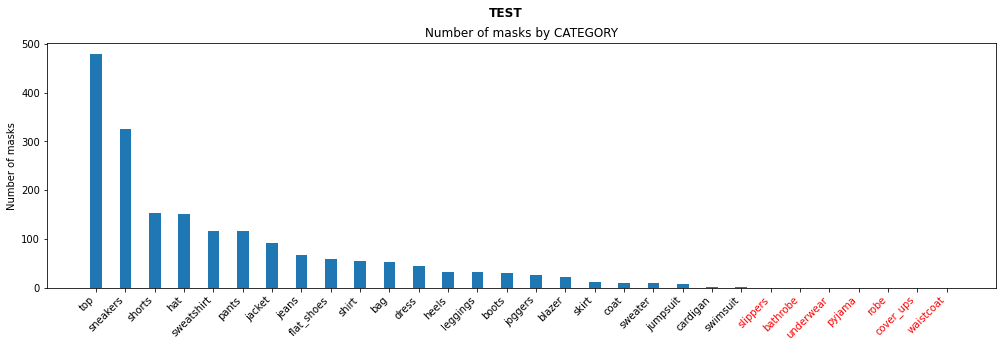

,category,#masks,frequency
0,top,478,25.300000
1,sneakers,325,17.200000
2,shorts,153,8.100000
3,hat,151,8.000000
4,sweatshirt,117,6.200000
5,pants,117,6.200000
6,jacket,92,4.900000
7,jeans,66,3.500000
8,flat_shoes,58,3.100000
9,shirt,55,2.900000


In [10]:
path_tst =  os.path.join(DIR, 'test/coco_test_500.json')
tst = json.load(open(path_tst))
show_all(tst, 'Test')